Epoch 1/30
469/469 [==============================] - 6s 11ms/step - loss: 52.2883
Epoch 2/30
469/469 [==============================] - 5s 10ms/step - loss: 42.1317
Epoch 3/30
469/469 [==============================] - 6s 12ms/step - loss: 40.9381
Epoch 4/30
469/469 [==============================] - 6s 12ms/step - loss: 40.2423
Epoch 5/30
469/469 [==============================] - 5s 11ms/step - loss: 39.6735
Epoch 6/30
469/469 [==============================] - 5s 10ms/step - loss: 39.1734
Epoch 7/30
469/469 [==============================] - 5s 10ms/step - loss: 38.7260
Epoch 8/30
469/469 [==============================] - 5s 10ms/step - loss: 38.3557
Epoch 9/30
469/469 [==============================] - 5s 11ms/step - loss: 38.0462
Epoch 10/30
469/469 [==============================] - 5s 11ms/step - loss: 37.7581
Epoch 11/30
469/469 [==============================] - 5s 10ms/step - loss: 37.5026
Epoch 12/30
469/469 [==============================] - 5s 11ms/step - loss: 37.2979
E

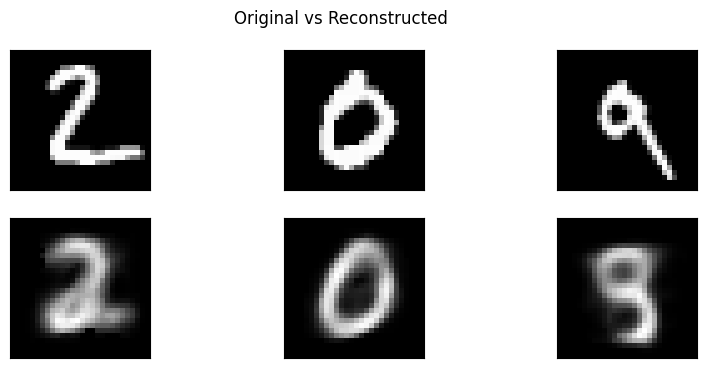

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, losses
from keras.datasets import mnist

# Load and prepare the MNIST dataset
# The MNIST dataset contains images of handwritten digits (0-9) with labels.
# We're loading the images and ignoring the labels since this is an unsupervised task.
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the pixel values to a range of 0 to 1 for easier processing and better training performance.
x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255.

# Flatten the 28x28 images into 1D vectors of size 784, as the VAE takes vectorized inputs.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# VAE Architecture
# Define the dimensionality of the latent space (compressed representation of the input).
latent_dim = 2  # We use 2 dimensions to enable visualization of the latent space.

# Encoder
# The encoder compresses input data into a smaller representation in the latent space.
encoder_inputs = layers.Input(shape=(784,))  # Input layer for 784-dimensional flattened image data.

# Add a dense (fully connected) layer with ReLU activation to learn a feature-rich representation.
x = layers.Dense(256, activation='relu')(encoder_inputs)

# Define two outputs: the mean (z_mean) and the log variance (z_log_var) of the latent space.
# These outputs allow the VAE to model data as a probabilistic distribution.
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Reparameterization Trick
# This trick allows gradients to pass through the random sampling step during training.
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean), mean=0., stddev=1.)  # Sample random noise.
    return z_mean + tf.exp(z_log_var / 2) * epsilon  # Combine z_mean, z_log_var, and noise to sample z.

z = layers.Lambda(sampling)([z_mean, z_log_var])  # Custom layer for reparameterization.

# Create the encoder model which outputs the mean, log variance, and sampled latent vector.
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
# The decoder reconstructs the input data from the latent space representation.
latent_inputs = layers.Input(shape=(latent_dim,))  # Input layer for the latent vector.

# Add a dense layer with ReLU activation to decode the latent vector into intermediate features.
x = layers.Dense(256, activation='relu')(latent_inputs)

# Final dense layer with sigmoid activation to reconstruct the original image.
decoder_outputs = layers.Dense(784, activation='sigmoid')(x)

# Create the decoder model.
decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')

# VAE Model (combining encoder and decoder)
# The VAE model combines the encoder and decoder.
# It takes the original input, passes it through the encoder to sample latent representations, and decodes it back.
vae_outputs = decoder(encoder(encoder_inputs)[2])  # Use only the sampled latent vector (z) for decoding.
vae = models.Model(encoder_inputs, vae_outputs, name='vae')

# Loss Function (reconstruction loss + KL divergence)
# Reconstruction Loss: Measures how well the reconstructed output matches the input.
reconstruction_loss = losses.mse(encoder_inputs, vae_outputs)
reconstruction_loss *= 784  # Scale loss by input dimensionality to balance with KL divergence.

# KL Divergence: Measures how closely the learned distribution matches a standard normal distribution.
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss)  # Average over all data points.
kl_loss *= -0.5  # KL divergence formula.

# Combine reconstruction and KL divergence losses into a single VAE loss.
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)  # Add the VAE loss to the model.

# Training
vae.compile(optimizer='adam')  # Compile the VAE with the Adam optimizer for efficient training.
vae.fit(x_train, x_train, epochs=30, batch_size=128)  # Train the VAE on the training data for 30 epochs.

# Test and Visualization
n_to_visualize = 3  # Number of test images to visualize.
digit_size = 28  # Dimension of the original images (28x28).

# Create a blank canvas to visualize original and reconstructed images.
figure = np.zeros((digit_size * 2, digit_size * n_to_visualize))  # Two rows: one for originals, one for reconstructions.

# Choose specific test images to visualize (indices are chosen arbitrarily here).
test_image_indices = [1, 3, 7]  # Feel free to change these indices.

# Extract the corresponding images from the test set.
images = x_test[test_image_indices]

# Generate reconstructions using the encoder and decoder.
_, _, encoded_images = encoder.predict(images)  # Get latent representations of the images.
decoded_images = decoder.predict(encoded_images)  # Reconstruct the images from the latent space.

# Populate the visualization canvas with original and reconstructed images.
for i, idx in enumerate(test_image_indices):
    # Add the original image to the top row.
    figure[0:digit_size, i * digit_size:(i + 1) * digit_size] = images[i].reshape(28, 28)

    # Add the reconstructed image to the bottom row.
    figure[digit_size:, i * digit_size:(i + 1) * digit_size] = decoded_images[i].reshape(28, 28)

# Plot the visualization canvas.
plt.figure(figsize=(10, 4))  # Set the figure size.
plt.suptitle('Original vs Reconstructed')  # Add a title to the figure.

for i in range(n_to_visualize):
    # Plot the original image.
    plt.subplot(2, n_to_visualize, i + 1)
    plt.imshow(figure[0:digit_size, i * digit_size:(i + 1) * digit_size], cmap='gray')
    plt.xticks([])  # Remove x-axis ticks.
    plt.yticks([])  # Remove y-axis ticks.

    # Plot the reconstructed image.
    plt.subplot(2, n_to_visualize, n_to_visualize + i + 1)
    plt.imshow(figure[digit_size:, i * digit_size:(i + 1) * digit_size], cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.show()  # Display the figure.


1/1 [==============================] - 0s 25ms/step


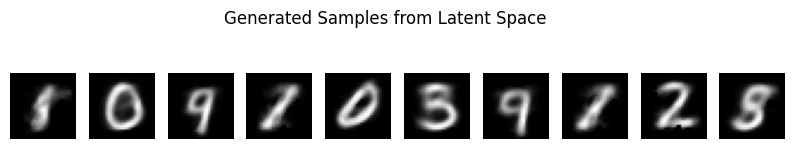

In [2]:
# Number of new samples to generate
n_samples = 10  # You can choose how many new digits to generate
digit_size = 28  # Each digit is 28x28 pixels

# Randomly sample points from the latent space
random_latent_vectors = np.random.normal(size=(n_samples, latent_dim))  # Shape: (n_samples, latent_dim)

# Decode the sampled latent vectors to generate new images
generated_images = decoder.predict(random_latent_vectors)  # Shape: (n_samples, 784)

# Visualize the generated samples
plt.figure(figsize=(10, 2))  # Create a canvas for visualization
for i in range(n_samples):
    ax = plt.subplot(1, n_samples, i + 1)  # Arrange subplots horizontally
    plt.imshow(generated_images[i].reshape(digit_size, digit_size), cmap='gray')  # Reshape and plot each image
    plt.axis('off')  # Turn off axis for cleaner display

plt.suptitle('Generated Samples from Latent Space')
plt.show()
